In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
    })
# plt.style.use("dark_background")
# plt.style.use("dark_background")

In [4]:
""" l = 0
r = 1
T_0 = 0
T = 7

b = 1
h = 0.1
dt = h**2
LAMBDA = dt/(h**2)

n_x = int(np.abs(l-r)/h)+2
n_t = int((T - T_0)/dt)+2

x = np.linspace(l, r, n_x)
t = np.linspace(T_0, T, n_t) """

' l = 0\nr = 1\nT_0 = 0\nT = 7\n\nb = 1\nh = 0.1\ndt = h**2\nLAMBDA = dt/(h**2)\n\nn_x = int(np.abs(l-r)/h)+2\nn_t = int((T - T_0)/dt)+2\n\nx = np.linspace(l, r, n_x)\nt = np.linspace(T_0, T, n_t) '

In [5]:
# Initial condition
def u_0(x):
    # x = x/10
    return 4*x*(1-x)
    return int(0.33 <= x and x<= 0.66)

In [6]:
# Fill in u[0] and set u to zero on the boundary
def popIC_DBC(x, f=u_0):
    u = f(x)
    u[0] = 0
    u[-1] = 0
    return u
    u = np.zeros((n_t, n_x), dtype='d')
    u[0] = [f(i) for i in x]
    u[0,0] = 0
    u[0,-1] = 0
    return u

# Fill in u[0] and set derivative to zero on boundary
def popIC_NBC(x, f=u_0):
    u = f(x)
    u[0] = u[2]
    u[-1] = u[-3]
    return u
    u = np.zeros((n_t, n_x), dtype='d')
    u[0] = [f(i) for i in x]
    u[0,1] = u[0,1]
    u[0,-1] = u[0,-2]
    return u

$$
		v_i^{n+1} = v_i^n +\lambda b\Big[\theta(v_{i+1}^{n+1} - 2v_i^{n+1} + v_{i-1}^{n+1})
		+ (1-\theta)(v_{i+1}^n - 2v_i^n + v^n_{i-1})\Big]
.$$

In [7]:
def buildAB(theta, b, LAMBDA, n_x, condition="NBC"):
    A = np.zeros((n_x, n_x))
    B = np.zeros((n_x, n_x))
    for i in range(0, n_x):
        for j in range(0, n_x):
            if i==j:
                A[i,i] = 1 + b*LAMBDA*2*theta
                B[i,i] = 1 - 2*b*LAMBDA*(1-theta)
            elif abs(i-j) == 1:
                A[i,j] = -1 * theta * b * LAMBDA
                B[i,j] = (1 - theta) * b * LAMBDA
    return A, B

In [8]:
def buildC(theta, b, LAMBDA, n_x, condition="NBC"):
    A,B = buildAB(theta, b, LAMBDA, n_x, condition)
    A[0][1] *= 2
    A[-1][-2] *= 2
    B[0][1] *= 2
    B[-1][-2] *= 2
    C = np.linalg.inv(A)@B
# TODO
    if condition == "NBC":
        C[0]= [ int(2==i) for i in range(n_x)]
        C[-1] = [int(i == n_x - 3) for i in range(n_x)]
    if condition == "DBC":
        C[0] = np.append(1, [0 for i in range(n_x-1)])
        C[-1] = np.append([0 for i in range(n_x-1)], 1)
    return C

In [9]:
def theta_scheme(Ctheta, condition, vn):
    vnPlusOne = Ctheta@vn
    # TODO
#    if condition == "DBC":
#        vnPlusOne[0], vnPlusOne[-1] = 0, 0
#    if condition == "NBC":
#        vnPlusOne[0] = vnPlusOne[2]
#        vnPlusOne[-1] = vnPlusOne[-3]
    return vnPlusOne

In [19]:
def run(theta, b, LAMBDA, boundary_condition='NBC', h=0.1, plot=True, save=True, l=0, r=1, T=7.05):
    T_0 = 0  

    # h = 0.01
    dt= LAMBDA * h**2

    n_x = int(np.abs(l-r)/h)+1
    n_t = int((T - T_0)/dt)+1

    x = np.linspace(l, r, n_x)
    t = np.linspace(T_0, T, n_t)

    Ctheta = buildC(theta, b, LAMBDA, n_x, condition=boundary_condition)
    # Atheta, Btheta = buildAB(theta, b, LAMBDA, n_x)    

    pop_function = eval('popIC_'+boundary_condition)

    v = np.zeros((n_t, n_x))
    v[0] = pop_function(x)

    for j in range(1, n_t):
        v[j] = Ctheta@v[j-1]
#        v[j] = theta_scheme(Ctheta, condition, v[j-1])
    
    # If asked for a plot, then plot
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.set_ylabel('$u(x,t)$')
        ax.set_xlabel('$x$')

        # plot each line on a separate plane
        for t in [0, 0.5, 0.1, 0.2, 0.3, 0.4, 0.8, 0.6, 0.7]:
            j = round(t/dt)
            ax.plot(x, v[j], label=f"$t={round(j*dt, 1)}$")
        
        ax.legend(loc='right')

        title = f"$\\theta={str(theta)}, b={str(b)}, \lambda b = {round(LAMBDA*b,2)}$"
        if boundary_condition == "NBC":
            title = '$u_x(0, t) = u_x(1,t) = 0$, ' + title
        elif boundary_condition == "DBC":
            title = '$u(0,t) = u(1,t) = 0$, ' + title
        else:
            title = boundary_condition + ' ' + title

        if (theta < 0.5) and (2*b*LAMBDA*(1-2*theta) > 1):
            title += " (Not $\ell^2$ stable)"
        ax.set_title(title)

        if save:
            plt.savefig(f"hw1q4-{str(theta)}-{str(b)}-{boundary_condition}.pdf",
                                                                        bbox_inches='tight')
    return v

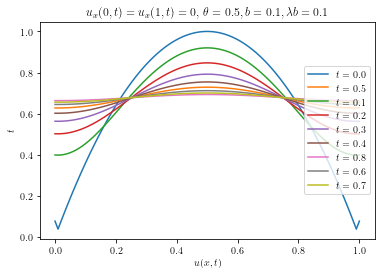

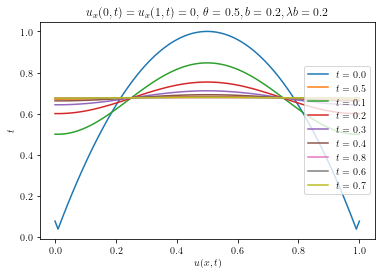

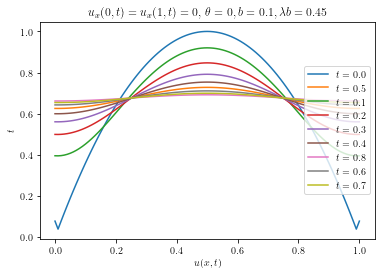

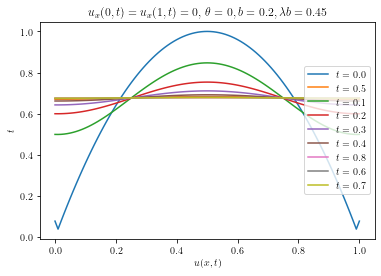

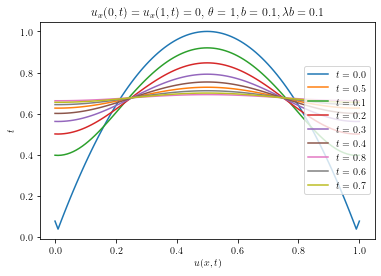

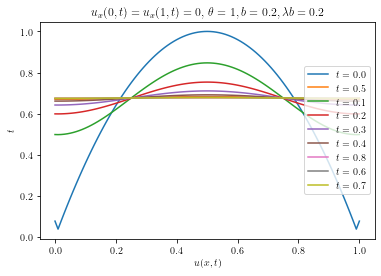

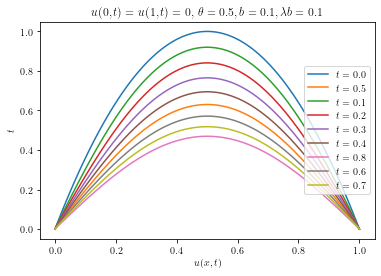

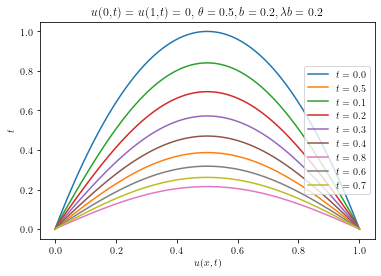

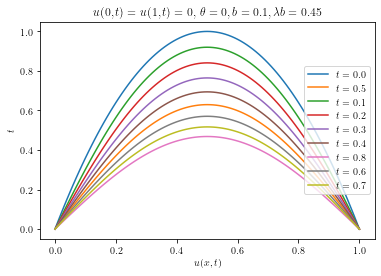

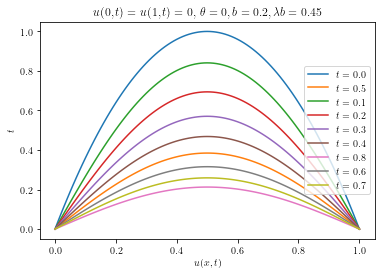

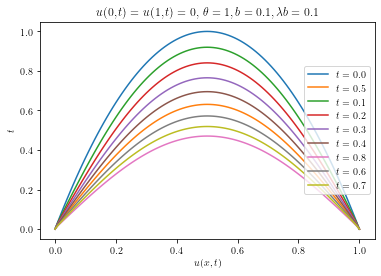

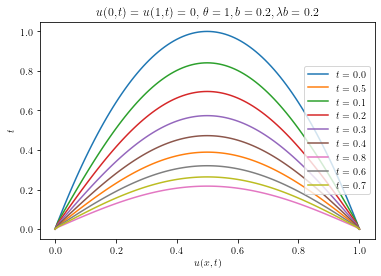

In [11]:
for condition in ["NBC", "DBC"]:
    for theta in [0.5, 0, 1]:
        for b in [0.1,0.2]:
            if theta == 0:
                LAMBDA = np.abs(0.45/b)
            else:
                LAMBDA = 1
            run(theta, b, LAMBDA, condition, plot=True, save=False, h=0.010)
#            break
#        break
#    break

In [12]:
theta = 0.5
b = 0.1
h = 0.01
LAMBDA = 1
v = run(theta, b, LAMBDA=LAMBDA, boundary_condition="NBC", h=0.005, plot=False, save=False)

Text(0.5, 0, '$u(x,t)$')

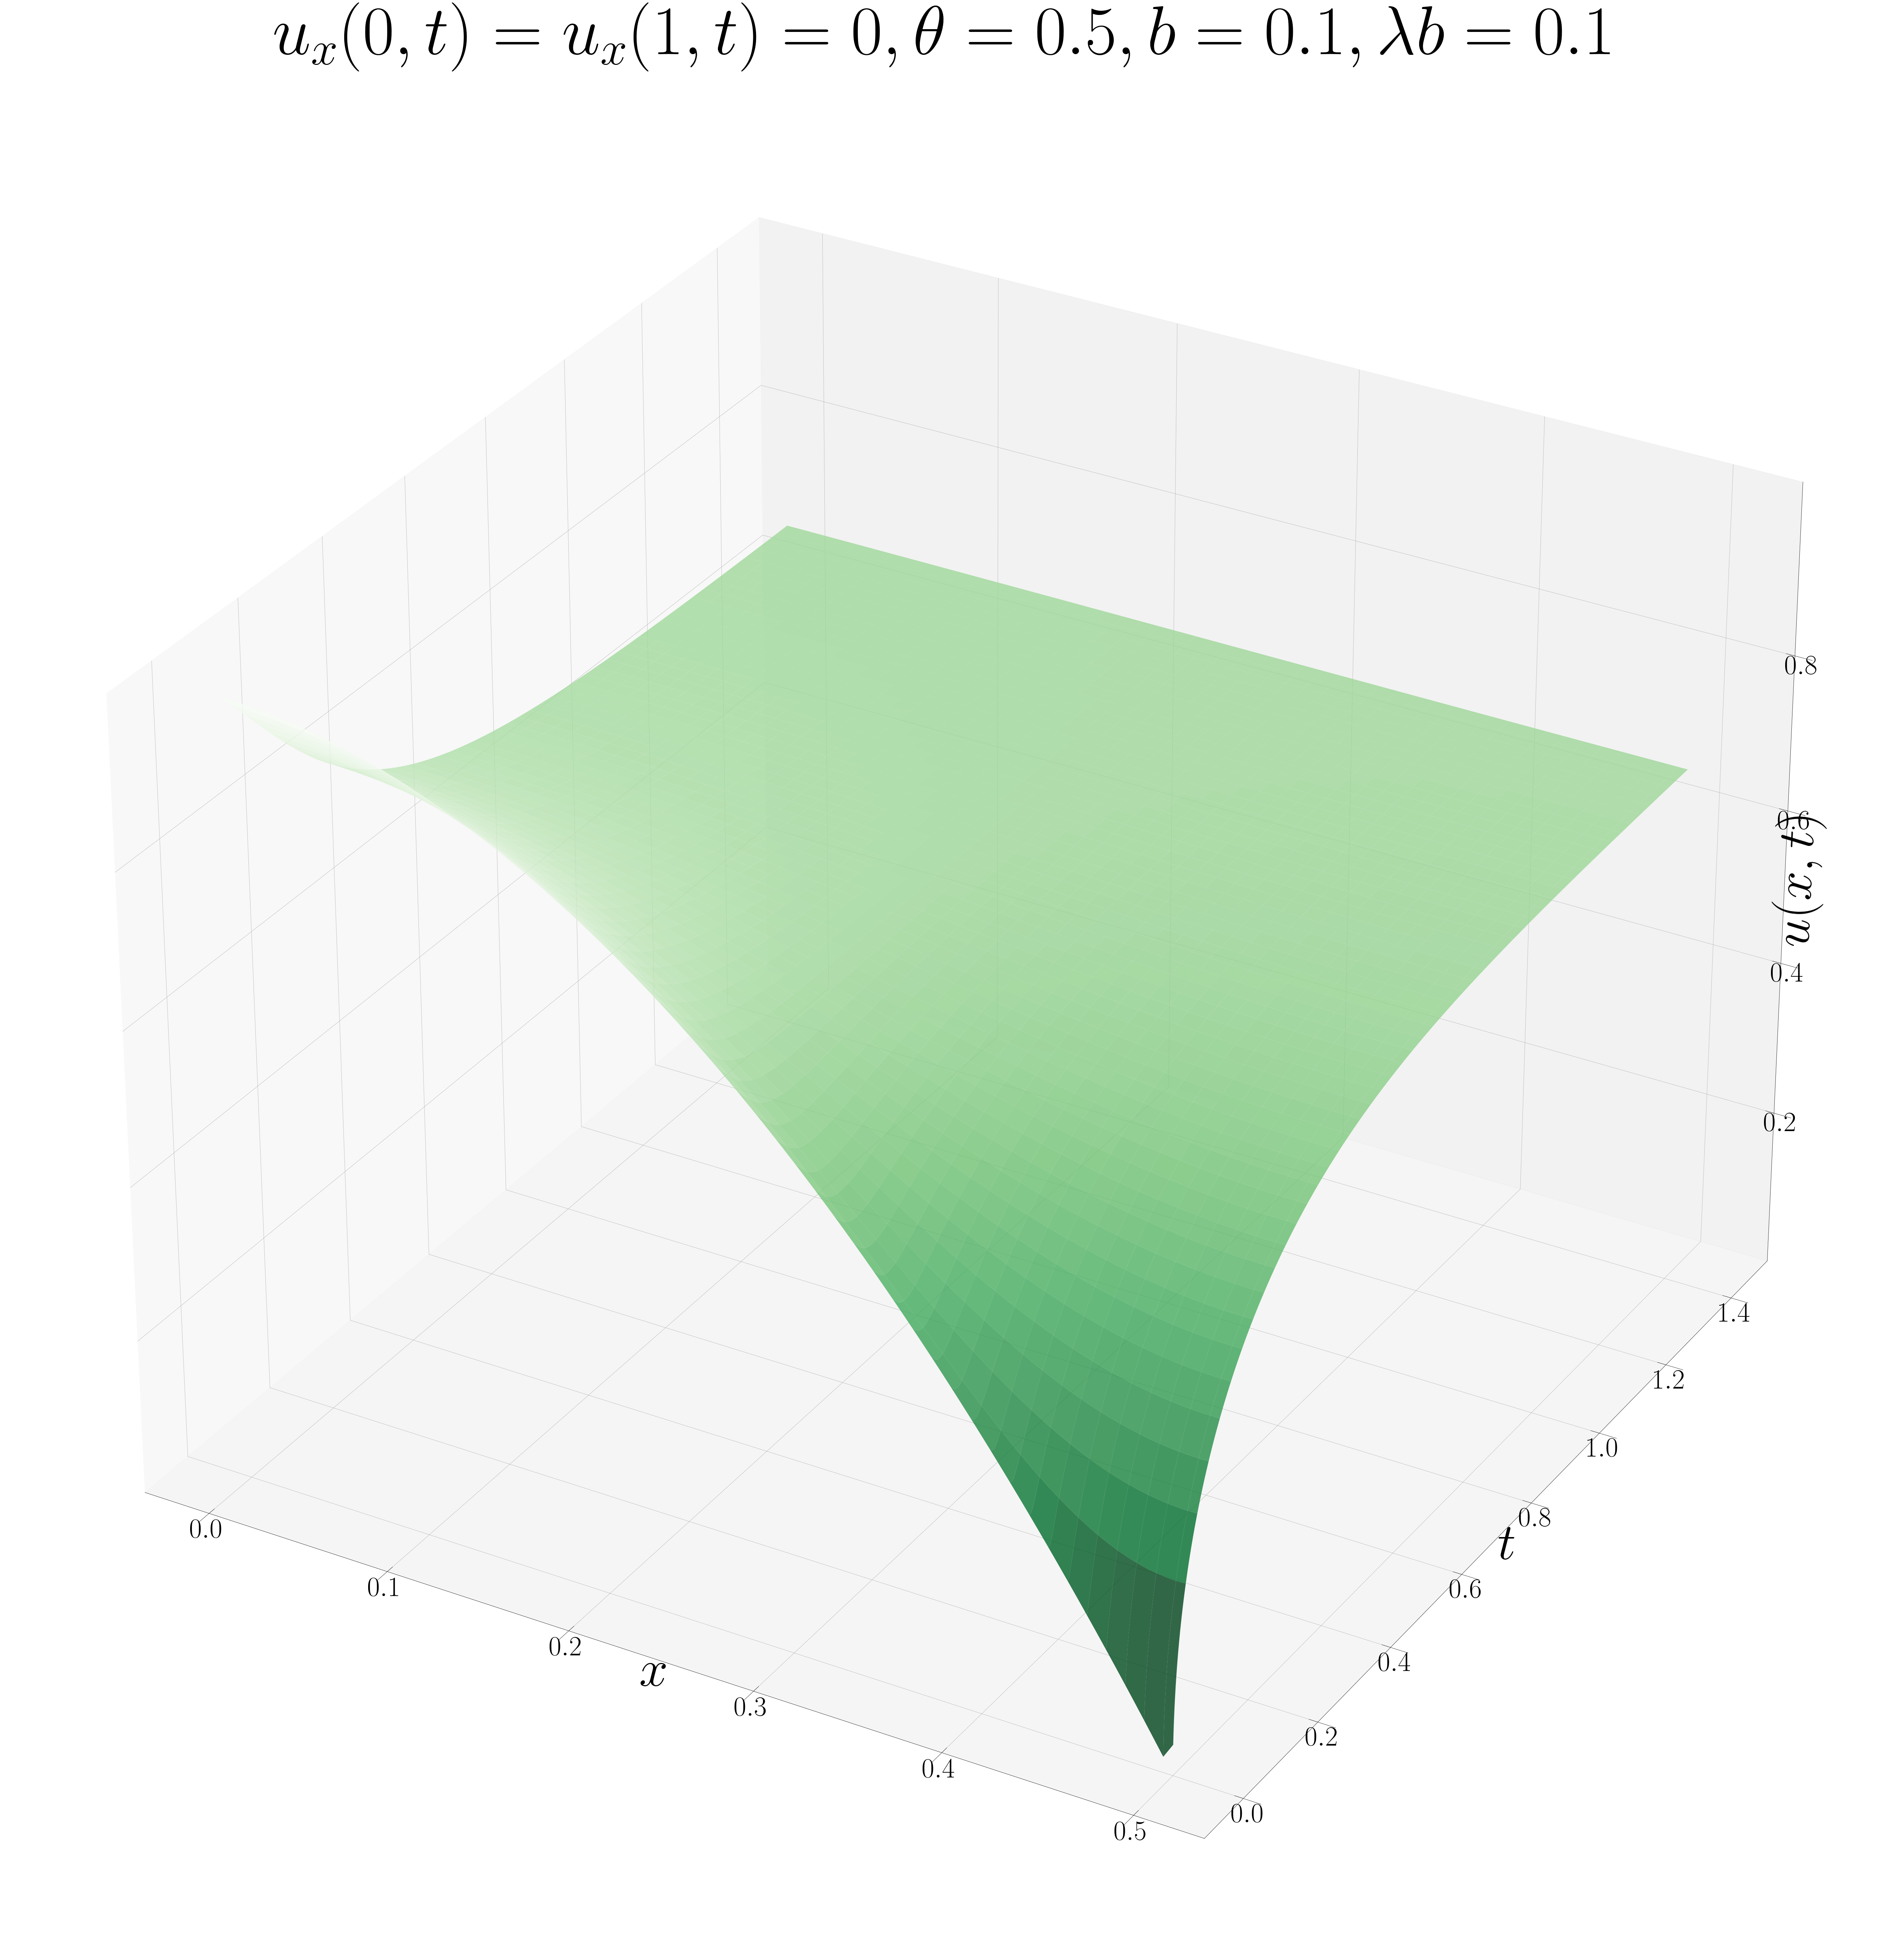

In [13]:
n_t, n_x = v.shape
factor = 5
xf = 2
n_t = int(n_t/factor)
n_x = int(n_x/xf)
x = np.linspace(0, 1/xf, n_x)
y = np.linspace(0, 7.05/factor, n_t)
X, Y = np.meshgrid(x,y)
Z = v[:n_t,-n_x:] 
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(100,100))
# ax.plot_wireframe(X, Y, Z, alpha=0.7)#, vmin=Z.min() * 2, cmap=cm.Reds)
ax.tick_params(axis='both', labelsize=80)
ax.set_title(f"$u_x(0,t)=u_x(1,t) = 0, \\theta={theta}, b = {b}, \\lambda b = {round(b*LAMBDA, 2)}$", fontsize=200)
ax.plot_surface(X, Y, Z, cmap=cm.Greens_r, alpha=0.8)
ax.set_xlabel("$x$", fontsize=150)
ax.set_ylabel("$t$", fontsize=150)
ax.set_zlabel("$u(x,t)$", fontsize=150)
# plt.savefig("hw1q4-surface.pdf", bbox_inches='tight')

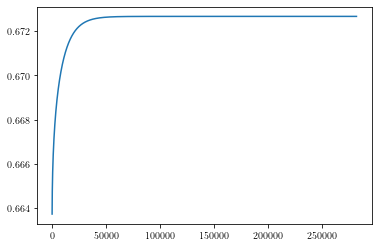

In [14]:
e = np.average(v, 1)
plt.plot(e)

In [57]:
# https://folk.ntnu.no/leifh/teaching/tkt4140/._main065.html
l = 0
r = 300
b = 100
dt = 0.25
h = 2.5
T_0 = 0
T = 4

LAMBDA = dt/(h**2)

n_x = int(np.abs(l-r)/h)+1
n_t = int((T - T_0)/dt)+1

x = np.linspace(l, r, n_x)
t = np.linspace(T_0, T, n_t)

def AlRod(x):
    if 100<= x<= 200:
        return 270
    elif 0<= x < 100 or 200<x<= 300:
        return 20
    else:
        raise Error

def popIC_NBC2(x, f=AlRod):
    u = [f(xi) for xi in x]
    return u



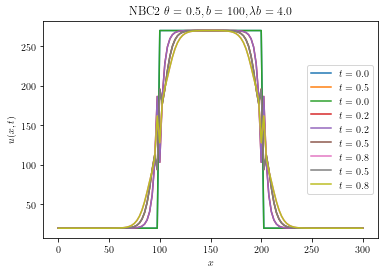

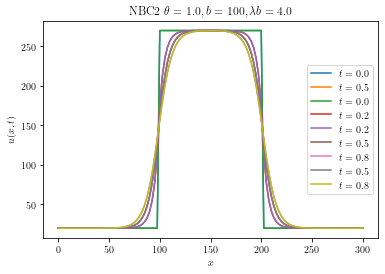

In [83]:
v = run(theta = 0.5, b = 100, LAMBDA=4/100, boundary_condition='NBC2', h=2.5, plot=True, save=False, l=0, r=300, T=4)
w = run(theta = 1.0, b = 100, LAMBDA=4/100, boundary_condition='NBC2', h=2.5, plot=True, save=False, l=0, r=300, T=4)

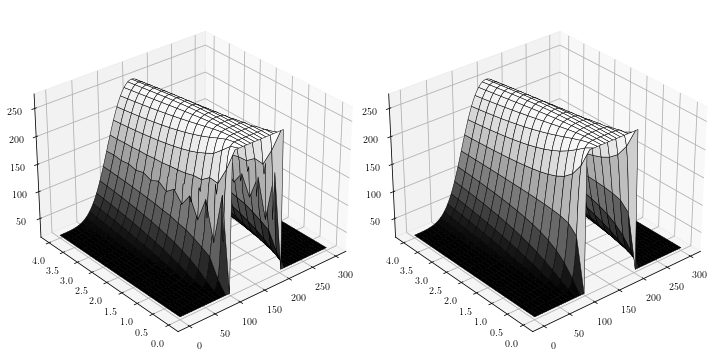

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10,20))
X, Y = np.meshgrid(x, t)
ax1.plot_surface(X,Y,v, color='white', shade=True, cmap='Greys_r', linewidth=0.5, edgecolors='k')
ax2.plot_surface(X,Y,w, color='white', shade=True, cmap='Greys_r', linewidth=0.5, edgecolors='k')
#ax.plot_wireframe(X, Y, Z, linewidth=1, edgecolors='k')
ax1.view_init(azim=-130)
ax2.view_init(azim=-130)
plt.tight_layout()